# Test 1 - Qwen3-1.7B vs Qwen3-4B

In [1]:
import time
import textworld
import textworld.gym
import numpy as np
import re
import os
from glob import glob
from typing import Mapping, Any
import pickle
import matplotlib.pyplot as plt

In [2]:
import torch
import accelerate
torch.set_default_device('cuda')
# torch.cuda.device("cuda")
# torch.backends.cuda.matmul.allow_tf32 = True
# torch.set_float32_matmul_precision('high')

In [3]:
model_name = "Qwen/Qwen3-1.7B"

In [3]:
model_name = "Qwen/Qwen3-4B"

In [4]:
from transformers import AutoModelForCausalLM, AutoTokenizer

# load the tokenizer and the model
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForCausalLM.from_pretrained(
    model_name,
    dtype="auto",
    device_map="auto"
)

tokenizer_config.json: 0.00B [00:00, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json:   0%|          | 0.00/11.4M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/726 [00:00<?, ?B/s]

model.safetensors.index.json: 0.00B [00:00, ?B/s]

Fetching 3 files:   0%|          | 0/3 [00:00<?, ?it/s]

model-00001-of-00003.safetensors:   0%|          | 0.00/3.96G [00:00<?, ?B/s]

model-00003-of-00003.safetensors:   0%|          | 0.00/99.6M [00:00<?, ?B/s]

model-00002-of-00003.safetensors:   0%|          | 0.00/3.99G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

## Play function

In [5]:
def play(agent, path, max_steps=100, n_episodes=10, verbose=True):
    torch.manual_seed(46)  # For reproducibility when using action sampling.

    infos_to_request = agent.infos_to_request
    infos_to_request.max_score = True  # Needed to normalize the scores.

    gamefiles = [path]
    if os.path.isdir(path):
        gamefiles = glob(os.path.join(path, "*.z8"))

    env_id = textworld.gym.register_games(gamefiles,
                                          request_infos=infos_to_request,
                                          max_episode_steps=max_steps)
    env = textworld.gym.make(env_id)  # Create a Gym environment to play the text game.
    if verbose:
        if os.path.isdir(path):
            print(os.path.dirname(path), end="")
        else:
            print(os.path.basename(path), end="")

    # Collect some statistics
    avg_moves, avg_scores, avg_norm_scores = [], [], []
    moves_scores_times_list = []
    
    for no_episode in range(n_episodes):
        episode_start = time.process_time()
        obs, infos = env.reset()  # Start new episode.

        score = 0
        done = False
        nb_moves = 0
        moves_scores_times = [(0, 0, 0)] # starting point
        
        while not done:
            command = agent.act(obs, score, done, infos)
            timestamp = time.process_time()
            obs, score, done, infos = env.step(command)
            nb_moves += 1
            moves_scores_times.append((nb_moves, score, timestamp - episode_start))

        agent.act(obs, score, done, infos)  # Let the agent know the game is done.
        moves_scores_times_list.append(moves_scores_times)

        if verbose:
            print(".", end="")
        avg_moves.append(nb_moves)
        avg_scores.append(score)
        avg_norm_scores.append(score / infos["max_score"])

    env.close()
    if verbose:
        if os.path.isdir(path):
            msg = "  \tavg. steps: {:5.1f}; avg. normalized score: {:4.1f} / {}."
            print(msg.format(np.mean(avg_moves), np.mean(avg_norm_scores), 1))
            if len(avg_moves) > 1:
                print(f"Detailed steps: {avg_moves}\t Detailed normalized scores: {avg_norm_scores}")
        else:
            msg = "  \tavg. steps: {:5.1f}; avg. score: {:4.1f} / {}."
            print(msg.format(np.mean(avg_moves), np.mean(avg_scores), infos["max_score"]))
            if len(avg_moves) > 1:
                print(f"Detailed steps: {avg_moves}\t Detailed scores: {avg_scores}")
        return moves_scores_times_list

## Agents

In [6]:
class LLMAgent(textworld.gym.Agent):
    """LLM from HuggingFace that acts as an agent."""
    model = None
    tokenizer = None
    context = ""

    token_think = "/think"
    token_nothink = "/no_think"
    id_token_open_think = None # <think> . TODO find it
    id_token_close_think = 151668 # </think>
    token_system = "<|im_start|>system\n"
    token_endofturn = "<|im_end|>\n"
    token_user = "<|im_start|>user\n"
    token_assistant = "<|im_start|>assistant\n"
    system_prompt = """
You are an assistant playing a textual game.
The user gives you information on the environment and you reply exclusively in the form \"verb noun\", like \"open box\" or \"take key\".
/no_think
"""
    first_move = False
    
    def __init__(self, model, tokenizer):
        self.model = model
        self.tokenizer = tokenizer
        self.initialize_context()

    def initialize_context(self):
        self.context = self.token_system + self.system_prompt + self.token_endofturn
        self.first_move = True

    @property
    def infos_to_request(self) -> textworld.EnvInfos:
        return textworld.EnvInfos(admissible_commands=True)

    def act(self, obs: str, score: int, done: bool, infos: Mapping[str, Any]) -> str:

        if done:
            self.initialize_context() # resets context
            return ":)"
            
        if self.first_move:
            self.first_move = False
            return "help"
        
        try:
            self.context += self.token_user + obs + self.token_endofturn
            self.context += self.token_assistant # induces model to generate answer
            
            input_ids = self.tokenizer.encode(
                self.context,
                return_tensors = "pt")
            
            generated_ids = self.model.generate(
                input_ids.to("cuda"),
                max_new_tokens = 100,
                eos_token_id = self.tokenizer.eos_token_id
                )
            output_ids = generated_ids[0][len(input_ids[0]):].tolist() 
            
            # parsing thinking content
            try:
                # index finding </think>
                index = len(output_ids) - output_ids[::-1].index(self.id_token_close_think)
            except ValueError:
                index = 0
            response = tokenizer.decode(output_ids[index:], skip_special_tokens=True).strip("\n")
            
            self.context += response + self.token_endofturn

            if len(response.split()) <= 10:
                command = response
            else: # more than 10 words, output is surely wrong
                command = "look"
            return command
            
        except KeyboardInterrupt:
            pass  # Try stopping the game prematurely.

In [7]:
class LLMAgentSelfEvaluate(LLMAgent):
    """LLM from HuggingFace that acts as an agent. It self-evaluates its status and moves."""

    selfeval_turn_counter = 0
    selfeval_turns = 5
    handheld = True
    verbose = False
    reads_own_reasoning = False

    def __init__(self, model, tokenizer, selfeval_turns = 5, handheld = True, verbose = False, reads_own_reasoning = False):
        """Initialization function.
        selfeval_turns: how many turns should pass between a self-evaluation and the next one.
        handheld: if this is set to True there are a few simple changes in the function that make it easier for the LLM to understand and correct its course
        """
        super().__init__(model, tokenizer)
        if selfeval_turns == 0:
            selfeval_turns = -1 # default value for deactivating self-evaluation
        self.selfeval_turns = selfeval_turns
        self.handheld = handheld
        self.verbose = verbose
        self.reads_own_reasoning = reads_own_reasoning

    def initialize_context(self):
        super().initialize_context()
        self.selfeval_turn_counter = 0

    def generate_response(self, think=False):
        if think:
            max_new_tokens = 20000 # allow reasoning models to be talkative
        else:
            max_new_tokens = 20 # reduce generation almost to a minimum
        
        input_ids = self.tokenizer.encode(
                self.context,
                return_tensors = "pt")
        try:
            generated_ids = self.model.generate(
                input_ids.to("cuda"),
                max_new_tokens = max_new_tokens,
                eos_token_id = self.tokenizer.eos_token_id
                )
            output_ids = generated_ids[0][len(input_ids[0]):].tolist()
        except:
            return "help" # model is in distress :)

        try:
            # index finding </think>
            index = len(output_ids) - output_ids[::-1].index(self.id_token_close_think)
        except ValueError:
            index = 0
        if think:
            thinking_response = tokenizer.decode(output_ids[:index], skip_special_tokens=True).strip("\n")
            response = tokenizer.decode(output_ids[index:], skip_special_tokens=True).replace("<think>", "").replace("</think>", "").strip("\n")
            return (thinking_response, response)
        else:
            response = tokenizer.decode(output_ids[index:], skip_special_tokens=True).replace("<think>", "").replace("</think>", "").strip("\n")
            return response

    def act(self, obs: str, score: int, done: bool, infos: Mapping[str, Any]) -> str:
        if done:
            self.initialize_context() # resets context
            return ":)"
        
        if self.selfeval_turn_counter == self.selfeval_turns: # time for self-evaluation
            self.selfeval_turn_counter = 0 # reset counter
            return self.self_evaluation(obs)
            
        try:
            self.context += self.token_user + obs + self.token_endofturn
            self.context += self.token_assistant # induces model to generate answer

            if self.first_move and self.handheld:
                self.first_move = False
                command = "help"
            else:
                response = self.generate_response()
                if len(response.split()) <= 10 or not self.handheld:
                    command = response
                else: # more than 10 words, output is surely wrong
                    command = "look"
            
            self.context += command + self.token_endofturn

            
            if self.verbose:
                print("GAME ++++++++++++++++++++++++++++++++++++++++++++++++++")
                print(obs)
                print("AGENT -------------------------------------------------")
                print(command)

            self.selfeval_turn_counter += 1
            return command
            
        except KeyboardInterrupt:
            pass  # Try stopping the game prematurely.

    def self_evaluation(self, obs) -> str :
        self_evaluation_prompt = """
Do you think you're making the right actions in the game? Do you think you're close to reaching the original goal? Think about it.
"""
        self.context += self.token_user + obs + self_evaluation_prompt + self.token_think + self.token_endofturn # induce thinking
        self.context += self.token_assistant
        
        (thinking_response, response) = self.generate_response(think=True)
        if self.verbose:
            print("GAME ++++++++++++++++++++++++++++++++++++++++++++++++++")
            print(obs + self_evaluation_prompt)
            print("SELF-EVALUATION: +-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-")
            print(thinking_response + response + self.token_nothink)

        if self.reads_own_reasoning:
            self.context += thinking_response + response + self.token_nothink + self.token_endofturn
        else:
            self.context += response + self.token_nothink + self.token_endofturn

        if len(response.split()) <= 10 or not self.handheld:
            command = response
        else: # more than 10 words, output is surely wrong
            command = "look"
        self.selfeval_turn_counter += 1
        return command
        

## Set up games

In [8]:
max_steps = 100
n_episodes = 10

In [9]:
!tw-make tw-simple --rewards dense --goal detailed --seed 0 --test --silent -f --output games/test-seed0.z8
!tw-make tw-simple --rewards dense --goal detailed --seed 1 --test --silent -f --output games/test-seed1.z8
!tw-make tw-simple --rewards dense --goal detailed --seed 2 --test --silent -f --output games/test-seed2.z8
!tw-make tw-simple --rewards dense --goal detailed --seed 3 --test --silent -f --output games/test-seed3.z8
!tw-make tw-simple --rewards dense --goal detailed --seed 4 --test --silent -f --output games/test-seed4.z8
!tw-make tw-simple --rewards dense --goal detailed --seed 5 --test --silent -f --output games/test-seed5.z8
!tw-make tw-simple --rewards dense --goal detailed --seed 6 --test --silent -f --output games/test-seed6.z8
!tw-make tw-simple --rewards dense --goal detailed --seed 7 --test --silent -f --output games/test-seed7.z8
!tw-make tw-simple --rewards dense --goal detailed --seed 8 --test --silent -f --output games/test-seed8.z8
!tw-make tw-simple --rewards dense --goal detailed --seed 9 --test --silent -f --output games/test-seed9.z8
!tw-make tw-simple --rewards dense --goal detailed --seed 10 --test --silent -f --output games/test-seed10.z8

# Run

In [12]:
for seed in range(1,11):
    results = play(LLMAgentSelfEvaluate(model, tokenizer, selfeval_turns = -1, handheld=False, verbose=False),
               f"./games/test-seed{seed}.z8", max_steps=max_steps, n_episodes=n_episodes)
    with open(f'Testing 1/1.7B_seed{seed}.pickle', 'wb') as f:
        pickle.dump(results, f)
        f.close()

test-seed1.z8..........  	avg. steps: 100.0; avg. score:  0.0 / 8.
Detailed steps: [100, 100, 100, 100, 100, 100, 100, 100, 100, 100]	 Detailed scores: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
test-seed2.z8..........  	avg. steps: 100.0; avg. score:  1.3 / 10.
Detailed steps: [100, 100, 100, 100, 100, 100, 100, 100, 100, 100]	 Detailed scores: [1, 1, 1, 1, 1, 1, 1, 1, 1, 4]
test-seed3.z8..........  	avg. steps: 100.0; avg. score:  1.4 / 7.
Detailed steps: [100, 100, 100, 100, 100, 100, 100, 100, 100, 100]	 Detailed scores: [1, 1, 1, 1, 5, 1, 1, 1, 1, 1]
test-seed4.z8..........  	avg. steps: 100.0; avg. score:  2.0 / 10.
Detailed steps: [100, 100, 100, 100, 100, 100, 100, 100, 100, 100]	 Detailed scores: [2, 2, 2, 2, 2, 2, 2, 2, 2, 2]
test-seed5.z8..........  	avg. steps: 100.0; avg. score:  4.0 / 7.
Detailed steps: [100, 100, 100, 100, 100, 100, 100, 100, 100, 100]	 Detailed scores: [4, 4, 4, 4, 4, 4, 4, 4, 4, 4]
test-seed6.z8..........  	avg. steps: 100.0; avg. score:  0.2 / 10.
Detailed steps:

In [9]:
for seed in range(1,11):
    results = play(LLMAgentSelfEvaluate(model, tokenizer, selfeval_turns = -1, handheld=False, verbose=False),
               f"./games/test-seed{seed}.z8", max_steps=max_steps, n_episodes=n_episodes)
    with open(f'Testing 1/4B_seed{seed}.pickle', 'wb') as f:
        pickle.dump(results, f)
        f.close()

test-seed1.z8..........  	avg. steps:  89.6; avg. score:  7.2 / 8.
Detailed steps: [100, 100, 100, 100, 100, 47, 100, 100, 49, 100]	 Detailed scores: [7, 7, 7, 7, 7, 8, 7, 7, 8, 7]
test-seed2.z8..........  	avg. steps: 100.0; avg. score:  8.0 / 10.
Detailed steps: [100, 100, 100, 100, 100, 100, 100, 100, 100, 100]	 Detailed scores: [9, 9, 9, 9, 9, 4, 9, 9, 9, 4]
test-seed3.z8..........  	avg. steps:   8.0; avg. score:  7.0 / 7.
Detailed steps: [8, 8, 8, 8, 8, 8, 8, 8, 8, 8]	 Detailed scores: [7, 7, 7, 7, 7, 7, 7, 7, 7, 7]
test-seed4.z8..........  	avg. steps: 100.0; avg. score:  5.5 / 10.
Detailed steps: [100, 100, 100, 100, 100, 100, 100, 100, 100, 100]	 Detailed scores: [2, 2, 2, 9, 2, 9, 9, 9, 2, 9]
test-seed5.z8..........  	avg. steps: 100.0; avg. score:  4.0 / 7.
Detailed steps: [100, 100, 100, 100, 100, 100, 100, 100, 100, 100]	 Detailed scores: [4, 4, 4, 4, 4, 4, 4, 4, 4, 4]
test-seed6.z8..........  	avg. steps:  91.2; avg. score:  9.1 / 10.
Detailed steps: [100, 100, 100, 100, 

# Visualization

In [11]:
seeds = range(1, 11)
results_list_1_7B = []
results_list_4B = []

for seed in seeds:
    with open(f'Testing 1/1.7B_seed{seed}.pickle', 'rb') as f:
        results_list_1_7B.append(pickle.load(f))
        f.close()
    with open(f'Testing 1/4B_seed{seed}.pickle', 'rb') as f:
        results_list_4B.append(pickle.load(f))
        f.close()

In [12]:
max_scores = [8, 10, 7, 10, 7, 10, 7, 10, 7, 7]
avg_scores_1_7B = []
avg_scores_4B = []

for seed in seeds:
    scores_of_final_steps = []
    for run in results_list_1_7B[seed-1]:
        scores_of_final_steps.append(run[-1][1])
    avg_scores_1_7B.append(np.mean(scores_of_final_steps) / max_scores[seed-1])

    scores_of_final_steps = []
    for run in results_list_4B[seed-1]:
        scores_of_final_steps.append(run[-1][1])
    avg_scores_4B.append(np.mean(scores_of_final_steps) / max_scores[seed-1])

In [18]:
print(avg_scores_1_7B)
print(avg_scores_4B)

[0.0, 0.13, 0.19999999999999998, 0.2, 0.5714285714285714, 0.02, 0.15714285714285717, 0.0, 0.14285714285714285, 0.2857142857142857]
[0.9, 0.8, 1.0, 0.55, 0.5714285714285714, 0.9099999999999999, 1.0, 0.93, 1.0, 1.0]


In [13]:
avg_times_1_7B = []
avg_times_4B = []

for seed in seeds:
    times_of_final_steps = []
    for run in results_list_1_7B[seed-1]:
        times_of_final_steps.append(run[-1][2])
    avg_times_1_7B.append(np.mean(times_of_final_steps))

    times_of_final_steps = []
    for run in results_list_4B[seed-1]:
        times_of_final_steps.append(run[-1][2])
    avg_times_4B.append(np.mean(times_of_final_steps))

In [38]:
print(avg_times_1_7B)
print(avg_times_4B)

[16.6312863671, 16.674585863100017, 15.095549504599996, 17.00770652959998, 17.497499273999995, 19.447194486599994, 18.014292129699992, 19.38664712999996, 14.100355692300013, 17.882568143800064]
[28.436508070499997, 31.7440423399, 1.2397813183000153, 49.16057651520005, 26.665991287099995, 41.816298050900016, 1.5289465187999896, 33.51782474239999, 1.659197742799961, 1.3803591473999859]


In [14]:
timeouts_1_7B = []
timeouts_4B = []
for seed in seeds:
    for run in results_list_1_7B[seed-1]:
        timeouts = []
        if run[-1][0] == 100:
            timeouts.append(True)
        else:
            timeouts.append(False)
    timeouts_1_7B.append(np.bincount(timeouts).argmax())

    for run in results_list_4B[seed-1]:
        timeouts = []
        if run[-1][0] == 100:
            timeouts.append(True)
        else:
            timeouts.append(False)
    timeouts_4B.append(np.bincount(timeouts).argmax())

In [65]:
print(timeouts_1_7B)
print(timeouts_4B)

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
[1, 1, 0, 1, 1, 1, 0, 0, 0, 0]


In [15]:
timeouts_4B[7] = 1 # manual correction...

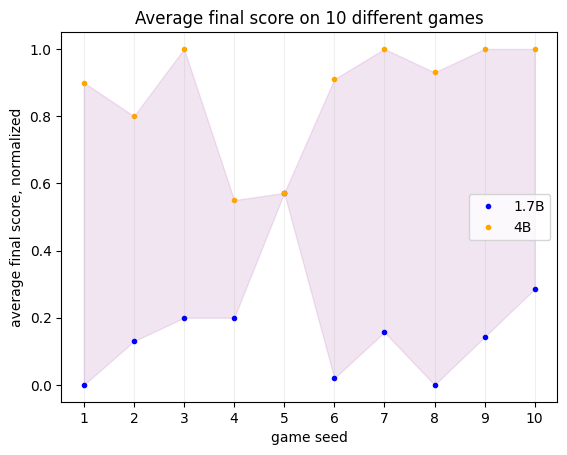

In [16]:
x = list(seeds)

fig, ax = plt.subplots()

ax.plot(x, avg_scores_1_7B, label="1.7B", marker=".", linestyle="", color="blue")
ax.plot(x, avg_scores_4B, label="4B", marker=".", linestyle="", color="orange")
# ax.fill_between(x, avg_scores_1_7B, alpha=0.1)
# ax.fill_between(x, avg_scores_4B, alpha=0.1)
ax.fill_between(x, avg_scores_1_7B, avg_scores_4B, alpha=0.1, color="purple")

ax.set_title("Average final score on 10 different games")
ax.set_xlabel('game seed')
ax.set_ylabel('average final score, normalized')

gridlines = np.arange(x[0], x[-1]+1, 1)
ax.set_xticks(gridlines)
ax.grid(axis="x", alpha=0.2)

ax.legend()
plt.show()

In [17]:
timeouted_1_7B_x = []
timeouted_1_7B_y = []
timeouted_4B_x = []
timeouted_4B_y = []

for i in range(len(x)):
    if timeouts_1_7B[i] == 1:
        timeouted_1_7B_x.append(x[i])
        timeouted_1_7B_y.append(avg_times_1_7B[i])
    if timeouts_4B[i] == 1:
        timeouted_4B_x.append(x[i])
        timeouted_4B_y.append(avg_times_4B[i])

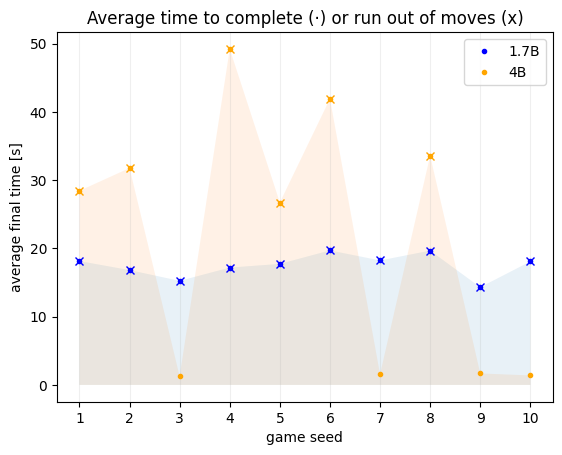

In [18]:
fig, ax = plt.subplots()
ax.plot(x, avg_times_1_7B, label="1.7B", marker=".", linestyle="", color="blue")
ax.plot(x, avg_times_4B, label="4B", marker=".", linestyle="", color="orange")
ax.plot(timeouted_1_7B_x, timeouted_1_7B_y, marker="x", linestyle="", color="blue")
ax.plot(timeouted_4B_x, timeouted_4B_y, marker="x", linestyle="", color="orange")

ax.fill_between(x, avg_times_1_7B, alpha=0.1)
ax.fill_between(x, avg_times_4B, alpha=0.1)

ax.set_title("Average time to complete (·) or run out of moves (x)")
ax.set_xlabel('game seed')
ax.set_ylabel('average final time [s]')

gridlines = np.arange(x[0], x[-1]+1, 1)
ax.set_xticks(gridlines)
ax.grid(axis="x", alpha=0.2)

ax.legend(["1.7B", "4B"])
plt.show()